# Описание проекта: промышленность
Чтобы оптимизировать производственные расходы, металлургический комбинат «Стальная птица» решил уменьшить потребление электроэнергии на этапе обработки стали. Для этого комбинату нужно контролировать температуру сплава. Ваша задача — построить модель, которая будет её предсказывать.

Заказчик хочет использовать разработанную модель для имитации технологического процесса. Ниже расскажем о деталях этого процесса. Их важно знать, прежде чем генерировать новые признаки.

# Описание этапа обработки
Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша.

Из сплава выводится сера (этот процесс — десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (от англ. tribe — «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (от англ. slab — «плита»).

In [59]:
!pip install phik
!pip install scikit-learn

In [60]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.compose import ColumnTransformer
from sklearn.metrics import make_scorer, f1_score, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.dummy import DummyRegressor
from catboost import Pool, CatBoostRegressor, cv
from lightgbm import LGBMRegressor
from sklearn.dummy import DummyRegressor

import phik

import os

In [61]:
def snake_casify(data):
    data.columns = data.columns.str.lower()
    data.columns = data.columns.str.replace(' ', '_')
    return data

In [62]:
def plot_hist(data, bins, title):
    analysis_chart = data.plot(
        kind = 'hist',
        bins = bins,
        grid = True,
        figsize = (8, 5),
        title = title,
    )
    analysis_chart.set_ylabel("Частота значений")
    return analysis_chart

## Загрузка данных

In [63]:
data_path = '/datasets/data_arc_new.csv'

if os.path.exists(data_path):
    data_arc_new = pd.read_csv(data_path, parse_dates=['Начало нагрева дугой', 'Конец нагрева дугой'])
else:
    print('Файл не найден!')
    
data_path = '/datasets/data_bulk_new.csv'
    
if os.path.exists(data_path):
    data_bulk_new = pd.read_csv(data_path)
else:
    print('Файл не найден!')
    
data_path = '/datasets/data_bulk_time_new.csv'
    
namelist = []
for i in range(1, 16):
    namelist.append(f'Bulk {i}')
    
if os.path.exists(data_path):
    data_bulk_time_new = pd.read_csv(data_path, parse_dates=namelist)
else:
    print('Файл не найден!')
    
data_path = '/datasets/data_gas_new.csv'
    
if os.path.exists(data_path):
    data_gas_new = pd.read_csv(data_path)
else:
    print('Файл не найден!')
    
data_path = '/datasets/data_temp_new.csv'
    
if os.path.exists(data_path):
    data_temp_new = pd.read_csv(data_path, parse_dates=['Время замера'])
else:
    print('Файл не найден!')
    
data_path = '/datasets/data_wire_new.csv'
    
if os.path.exists(data_path):
    data_wire_new = pd.read_csv(data_path)
else:
    print('Файл не найден!')
    
data_path = '/datasets/data_wire_time_new.csv'

namelist = []
for i in range(1, 10):
    namelist.append(f'Wire {i}')

if os.path.exists(data_path):
    data_wire_time_new = pd.read_csv(data_path, parse_dates=namelist)
else:
    print('Файл не найден!')

## Исследовательский анализ и предобработка данных

In [64]:
display(data_arc_new.info())
display(data_arc_new.describe())
display(data_arc_new.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   Начало нагрева дугой  14876 non-null  datetime64[ns]
 2   Конец нагрева дугой   14876 non-null  datetime64[ns]
 3   Активная мощность     14876 non-null  float64       
 4   Реактивная мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


None

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
count,14876.000000,14876,14876,14876.000000,14876.000000
mean,1615.220422,2019-07-05 12:25:51.921081088,2019-07-05 12:28:43.592027392,0.662752,0.438986
min,1.000000,2019-05-03 11:02:14,2019-05-03 11:06:02,0.223120,-715.479924
25%,806.000000,2019-06-03 23:18:23.249999872,2019-06-03 23:21:35,0.467115,0.337175
50%,1617.000000,2019-07-03 01:31:26.500000,2019-07-03 01:35:13,0.599587,0.441639
75%,2429.000000,2019-08-07 22:52:20.750000128,2019-08-07 22:56:47,0.830070,0.608201
max,3241.000000,2019-09-06 17:24:54,2019-09-06 17:26:15,1.463773,1.270284
std,934.571502,NaN,NaN,0.258885,5.873485


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


In [65]:
display(data_bulk_new.info())
display(data_bulk_new.describe())
display(data_bulk_new.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


None

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [66]:
display(data_bulk_time_new.info())
display(data_bulk_time_new.describe())
display(data_bulk_time_new.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3129 non-null   int64         
 1   Bulk 1   252 non-null    datetime64[ns]
 2   Bulk 2   22 non-null     datetime64[ns]
 3   Bulk 3   1298 non-null   datetime64[ns]
 4   Bulk 4   1014 non-null   datetime64[ns]
 5   Bulk 5   77 non-null     datetime64[ns]
 6   Bulk 6   576 non-null    datetime64[ns]
 7   Bulk 7   25 non-null     datetime64[ns]
 8   Bulk 8   1 non-null      datetime64[ns]
 9   Bulk 9   19 non-null     datetime64[ns]
 10  Bulk 10  176 non-null    datetime64[ns]
 11  Bulk 11  177 non-null    datetime64[ns]
 12  Bulk 12  2450 non-null   datetime64[ns]
 13  Bulk 13  18 non-null     datetime64[ns]
 14  Bulk 14  2806 non-null   datetime64[ns]
 15  Bulk 15  2248 non-null   datetime64[ns]
dtypes: datetime64[ns](15), int64(1)
memory usage: 391.2 KB


None

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252,22,1298,1014,77,576,25,1,19,176,177,2450,18,2806,2248
mean,1624.383509,2019-06-29 23:24:44.769841152,2019-07-12 07:57:13.045454592,2019-07-08 13:50:14.630970624,2019-07-03 11:17:28.834319616,2019-07-13 17:18:29.090908928,2019-07-06 13:50:06.345486080,2019-07-27 18:09:05.079999744,2019-07-08 17:14:53,2019-06-23 08:08:47.578947328,2019-07-06 23:55:10.954545408,2019-07-15 07:01:00.615819264,2019-07-05 22:55:11.468571392,2019-07-01 18:32:46.944444416,2019-07-06 07:17:48.372772608,2019-07-06 13:24:51.912366336
min,1.000000,2019-05-03 17:42:46,2019-05-07 15:39:35,2019-05-03 20:40:25,2019-05-03 11:28:48,2019-05-07 15:19:17,2019-05-03 19:09:15,2019-05-07 18:11:01,2019-07-08 17:14:53,2019-05-14 11:57:58,2019-05-06 07:54:02,2019-05-05 23:43:24,2019-05-03 11:24:31,2019-05-05 02:10:21,2019-05-03 11:14:50,2019-05-03 11:10:43
25%,816.000000,2019-05-29 14:48:48.500000,2019-05-28 02:29:31.500000,2019-06-08 03:50:23.500000,2019-05-30 21:36:11.249999872,2019-06-19 23:32:44,2019-06-06 22:46:10.500000,2019-07-20 23:48:47,2019-07-08 17:14:53,2019-05-14 14:31:08,2019-06-02 05:12:00.500000,2019-06-14 20:24:48,2019-06-03 12:48:47.249999872,2019-05-29 10:43:31.249999872,2019-06-04 04:50:42,2019-06-04 11:28:18
50%,1622.000000,2019-06-25 11:09:13,2019-07-27 17:18:38.500000,2019-07-04 09:31:42,2019-06-28 03:44:42.500000,2019-07-25 17:59:41,2019-07-09 03:34:57.500000,2019-07-27 18:07:02,2019-07-08 17:14:53,2019-05-14 16:55:09,2019-07-06 07:05:20,2019-07-24 11:17:22,2019-07-03 01:32:00,2019-07-01 12:59:36.500000,2019-07-03 21:54:13.500000,2019-07-03 16:43:28.500000
75%,2431.000000,2019-07-31 05:58:18.249999872,2019-08-13 02:20:08,2019-08-11 01:00:36.750000128,2019-08-04 04:15:46.500000,2019-08-13 04:23:23,2019-08-07 18:55:01.249999872,2019-08-13 04:19:43,2019-07-08 17:14:53,2019-08-16 05:43:31,2019-08-04 02:23:35.750000128,2019-08-11 05:21:01,2019-08-08 14:55:05.249999872,2019-08-04 23:32:00.249999872,2019-08-09 04:22:40.500000,2019-08-09 09:18:31.750000128
max,3241.000000,2019-09-05 09:11:32,2019-08-13 11:47:39,2019-09-06 12:26:52,2019-09-05 03:35:21,2019-09-02 18:16:52,2019-09-06 16:24:28,2019-09-05 19:07:49,2019-07-08 17:14:53,2019-08-16 09:11:56,2019-09-04 10:03:22,2019-09-06 05:03:14,2019-09-06 15:01:44,2019-09-01 01:53:02,2019-09-06 17:26:33,2019-09-06 17:23:15
std,933.337642,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaT,NaT,NaT,2019-05-03 11:28:48,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:24:31,NaT,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaT,NaT,NaT,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:53:30,NaT,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaT,NaT,NaT,2019-05-03 12:32:39,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:27:13,NaT,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaT,NaT,NaT,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:58:00,NaT,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,2019-05-03 13:34:12,2019-05-03 13:30:47


In [67]:
display(data_gas_new.info())
display(data_gas_new.describe())
display(data_gas_new.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [68]:
display(data_temp_new.info())
display(data_temp_new.describe())
display(data_temp_new.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           18092 non-null  int64         
 1   Время замера  18092 non-null  datetime64[ns]
 2   Температура   14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 424.2 KB


None

,key,Время замера,Температура
count,18092.000000,18092,14665.000000
mean,1616.460977,2019-07-05 13:36:58.791620608,1590.722741
min,1.000000,2019-05-03 11:02:04,1191.000000
25%,807.750000,2019-06-04 00:35:01.249999872,1580.000000
50%,1618.000000,2019-07-03 02:11:48,1590.000000
75%,2429.000000,2019-08-07 23:10:05.249999872,1599.000000
max,3241.000000,2019-09-06 17:30:05,1705.000000
std,934.641385,NaN,20.394381


,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


In [69]:
display(data_wire_new.info())
display(data_wire_new.describe())
display(data_wire_new.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [70]:
display(data_wire_time_new.info())
display(data_wire_time_new.describe())
display(data_wire_time_new.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     3081 non-null   int64         
 1   Wire 1  3055 non-null   datetime64[ns]
 2   Wire 2  1079 non-null   datetime64[ns]
 3   Wire 3  63 non-null     datetime64[ns]
 4   Wire 4  14 non-null     datetime64[ns]
 5   Wire 5  1 non-null      datetime64[ns]
 6   Wire 6  73 non-null     datetime64[ns]
 7   Wire 7  11 non-null     datetime64[ns]
 8   Wire 8  19 non-null     datetime64[ns]
 9   Wire 9  29 non-null     datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB


None

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055,1079,63,14,1,73,11,19,29
mean,1623.426485,2019-07-05 23:22:34.279541760,2019-07-07 01:07:08.735866624,2019-07-10 15:09:58.650793472,2019-07-11 13:44:37,2019-08-13 06:14:30,2019-07-07 11:51:15.095890432,2019-08-07 01:16:08.090909184,2019-06-23 07:47:49.052631552,2019-07-01 11:56:04.793103616
min,1.000000,2019-05-03 11:06:19,2019-05-03 13:15:34,2019-05-04 04:34:27,2019-05-07 15:19:17,2019-08-13 06:14:30,2019-05-07 14:46:05,2019-07-27 05:49:05,2019-05-14 11:29:24,2019-05-04 17:21:27
25%,823.000000,2019-06-04 19:30:11.500000,2019-06-05 14:50:26.500000,2019-06-11 14:17:38.500000,2019-07-20 17:58:53.750000128,2019-08-13 06:14:30,2019-05-08 21:47:30,2019-07-27 16:27:27,2019-05-14 14:20:07.500000,2019-06-09 19:36:17
50%,1619.000000,2019-07-03 06:36:23,2019-07-04 23:13:39,2019-07-21 10:04:47,2019-07-27 05:45:26.500000,2019-08-13 06:14:30,2019-07-28 05:00:32,2019-08-12 21:48:11,2019-05-14 16:55:09,2019-06-11 10:10:21
75%,2434.000000,2019-08-08 08:56:06.500000,2019-08-08 23:15:17,2019-08-12 22:54:46,2019-07-27 16:20:04.750000128,2019-08-13 06:14:30,2019-08-13 13:33:02,2019-08-13 02:02:55.500000,2019-08-16 05:06:53.500000,2019-08-09 06:49:04
max,3241.000000,2019-09-06 17:10:06,2019-09-06 07:35:40,2019-09-02 07:14:44,2019-08-13 03:16:45,2019-08-13 06:14:30,2019-08-18 19:10:56,2019-08-13 10:25:22,2019-08-16 08:56:23,2019-09-03 12:55:23
std,932.996726,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,3,2019-05-03 12:11:46,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,4,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaT,NaT,NaT,NaT,NaT,NaT,NaT


Для начала приведём признаки к *snake_case* и переименуем их, чтобы легче определять их смысл.

In [71]:
data_bulk_new = data_bulk_new.rename(
    columns = {
        'Bulk 1' : 'объём_подаваемого_материала 1',
        'Bulk 2' : 'объём подаваемого материала 2',
        'Bulk 3' : 'объём подаваемого материала 3',
        'Bulk 4' : 'объём подаваемого материала 4',
        'Bulk 5' : 'объём подаваемого материала 5',
        'Bulk 6' : 'объём подаваемого материала 6',
        'Bulk 7' : 'объём подаваемого материала 7',
        'Bulk 8' : 'объём подаваемого материала 8',
        'Bulk 9' : 'объём подаваемого материала 9',
        'Bulk 10' : 'объём подаваемого материала 10',
        'Bulk 11' : 'объём подаваемого материала 11',
        'Bulk 12' : 'объём подаваемого материала 12',
        'Bulk 13' : 'объём подаваемого материала 13',
        'Bulk 14' : 'объём подаваемого материала 14',
        'Bulk 15' : 'объём подаваемого материала 15'
    }
)

In [72]:
data_bulk_time_new = data_bulk_time_new.rename(
    columns = {
        'Bulk 1' : 'время_подачи_материала 1',
        'Bulk 2' : 'время подачи материала 2',
        'Bulk 3' : 'время подачи материала 3',
        'Bulk 4' : 'время подачи материала 4',
        'Bulk 5' : 'время подачи материала 5',
        'Bulk 6' : 'время подачи материала 6',
        'Bulk 7' : 'время подачи материала 7',
        'Bulk 8' : 'время подачи материала 8',
        'Bulk 9' : 'время подачи материала 9',
        'Bulk 10' : 'время подачи материала 10',
        'Bulk 11' : 'время подачи материала 11',
        'Bulk 12' : 'время подачи материала 12',
        'Bulk 13' : 'время подачи материала 13',
        'Bulk 14' : 'время подачи материала 14',
        'Bulk 15' : 'время подачи материала 15'
    }
)

In [73]:
data_gas_new = data_gas_new.rename(columns = {'Газ 1' : 'объём подаваемого газа 1'})

In [74]:
data_wire_new = data_wire_new.rename(
    columns = {
        'Wire 1' : 'объём подаваемых проволочных материалов 1',
        'Wire 2' : 'объём подаваемых проволочных материалов 2',
        'Wire 3' : 'объём подаваемых проволочных материалов 3',
        'Wire 4' : 'объём подаваемых проволочных материалов 4',
        'Wire 5' : 'объём подаваемых проволочных материалов 5',
        'Wire 6' : 'объём подаваемых проволочных материалов 6',
        'Wire 7' : 'объём подаваемых проволочных материалов 7',
        'Wire 8' : 'объём подаваемых проволочных материалов 8',
        'Wire 9' : 'объём подаваемых проволочных материалов 9'
    }
)

In [75]:
data_wire_time_new = data_wire_time_new.rename(
    columns = {
        'Wire 1' : 'время подачи проволочных материалов 1',
        'Wire 2' : 'время подачи проволочных материалов 2',
        'Wire 3' : 'время подачи проволочных материалов 3',
        'Wire 4' : 'время подачи проволочных материалов 4',
        'Wire 5' : 'время подачи проволочных материалов 5',
        'Wire 6' : 'время подачи проволочных материалов 6',
        'Wire 7' : 'время подачи проволочных материалов 7',
        'Wire 8' : 'время подачи проволочных материалов 8',
        'Wire 9' : 'время подачи проволочных материалов 9'
    }
)

In [76]:
data_arc_new = snake_casify(data_arc_new)
data_bulk_new = snake_casify(data_bulk_new)
data_bulk_time_new = snake_casify(data_bulk_time_new)
data_gas_new = snake_casify(data_gas_new)
data_temp_new = snake_casify(data_temp_new)
data_wire_new = snake_casify(data_wire_new)
data_wire_time_new = snake_casify(data_wire_time_new)

В данных обнаружено много пропусков, избавимся от них.

Пропуски во входных признаках будем заполнять нулями, а пропуски в целевом признаке удалим уже после объединения таблиц.

In [77]:
data_bulk_new = data_bulk_new.fillna(0)
data_temp_new = data_temp_new.fillna(0)
data_wire_new = data_wire_new.fillna(0)

In [78]:
data_bulk_new.info()
data_bulk_new.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   key                             3129 non-null   int64  
 1   объём_подаваемого_материала_1   3129 non-null   float64
 2   объём_подаваемого_материала_2   3129 non-null   float64
 3   объём_подаваемого_материала_3   3129 non-null   float64
 4   объём_подаваемого_материала_4   3129 non-null   float64
 5   объём_подаваемого_материала_5   3129 non-null   float64
 6   объём_подаваемого_материала_6   3129 non-null   float64
 7   объём_подаваемого_материала_7   3129 non-null   float64
 8   объём_подаваемого_материала_8   3129 non-null   float64
 9   объём_подаваемого_материала_9   3129 non-null   float64
 10  объём_подаваемого_материала_10  3129 non-null   float64
 11  объём_подаваемого_материала_11  3129 non-null   float64
 12  объём_подаваемого_материала_12  31

,key,объём_подаваемого_материала_1,объём_подаваемого_материала_2,объём_подаваемого_материала_3,объём_подаваемого_материала_4,объём_подаваемого_материала_5,объём_подаваемого_материала_6,объём_подаваемого_материала_7,объём_подаваемого_материала_8,объём_подаваемого_материала_9,объём_подаваемого_материала_10,объём_подаваемого_материала_11,объём_подаваемого_материала_12,объём_подаваемого_материала_13,объём_подаваемого_материала_14,объём_подаваемого_материала_15
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0


In [79]:
data_bulk_time_new.info()
data_bulk_time_new.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   key                        3129 non-null   int64         
 1   время_подачи_материала_1   252 non-null    datetime64[ns]
 2   время_подачи_материала_2   22 non-null     datetime64[ns]
 3   время_подачи_материала_3   1298 non-null   datetime64[ns]
 4   время_подачи_материала_4   1014 non-null   datetime64[ns]
 5   время_подачи_материала_5   77 non-null     datetime64[ns]
 6   время_подачи_материала_6   576 non-null    datetime64[ns]
 7   время_подачи_материала_7   25 non-null     datetime64[ns]
 8   время_подачи_материала_8   1 non-null      datetime64[ns]
 9   время_подачи_материала_9   19 non-null     datetime64[ns]
 10  время_подачи_материала_10  176 non-null    datetime64[ns]
 11  время_подачи_материала_11  177 non-null    datetime64[ns]
 12  время_

,key,время_подачи_материала_1,время_подачи_материала_2,время_подачи_материала_3,время_подачи_материала_4,время_подачи_материала_5,время_подачи_материала_6,время_подачи_материала_7,время_подачи_материала_8,время_подачи_материала_9,время_подачи_материала_10,время_подачи_материала_11,время_подачи_материала_12,время_подачи_материала_13,время_подачи_материала_14,время_подачи_материала_15
0,1,NaT,NaT,NaT,2019-05-03 11:28:48,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:24:31,NaT,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaT,NaT,NaT,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:53:30,NaT,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaT,NaT,NaT,2019-05-03 12:32:39,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:27:13,NaT,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaT,NaT,NaT,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:58:00,NaT,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,2019-05-03 13:34:12,2019-05-03 13:30:47


In [80]:
data_wire_new.info()
data_wire_new.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   key                                        3081 non-null   int64  
 1   объём_подаваемых_проволочных_материалов_1  3081 non-null   float64
 2   объём_подаваемых_проволочных_материалов_2  3081 non-null   float64
 3   объём_подаваемых_проволочных_материалов_3  3081 non-null   float64
 4   объём_подаваемых_проволочных_материалов_4  3081 non-null   float64
 5   объём_подаваемых_проволочных_материалов_5  3081 non-null   float64
 6   объём_подаваемых_проволочных_материалов_6  3081 non-null   float64
 7   объём_подаваемых_проволочных_материалов_7  3081 non-null   float64
 8   объём_подаваемых_проволочных_материалов_8  3081 non-null   float64
 9   объём_подаваемых_проволочных_материалов_9  3081 non-null   float64
dtypes: float64(9), int64(1)


,key,объём_подаваемых_проволочных_материалов_1,объём_подаваемых_проволочных_материалов_2,объём_подаваемых_проволочных_материалов_3,объём_подаваемых_проволочных_материалов_4,объём_подаваемых_проволочных_материалов_5,объём_подаваемых_проволочных_материалов_6,объём_подаваемых_проволочных_материалов_7,объём_подаваемых_проволочных_материалов_8,объём_подаваемых_проволочных_материалов_9
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [81]:
data_wire_time_new.info()
data_wire_time_new.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   key                                    3081 non-null   int64         
 1   время_подачи_проволочных_материалов_1  3055 non-null   datetime64[ns]
 2   время_подачи_проволочных_материалов_2  1079 non-null   datetime64[ns]
 3   время_подачи_проволочных_материалов_3  63 non-null     datetime64[ns]
 4   время_подачи_проволочных_материалов_4  14 non-null     datetime64[ns]
 5   время_подачи_проволочных_материалов_5  1 non-null      datetime64[ns]
 6   время_подачи_проволочных_материалов_6  73 non-null     datetime64[ns]
 7   время_подачи_проволочных_материалов_7  11 non-null     datetime64[ns]
 8   время_подачи_проволочных_материалов_8  19 non-null     datetime64[ns]
 9   время_подачи_проволочных_материалов_9  29 non-null     datetime

,key,время_подачи_проволочных_материалов_1,время_подачи_проволочных_материалов_2,время_подачи_проволочных_материалов_3,время_подачи_проволочных_материалов_4,время_подачи_проволочных_материалов_5,время_подачи_проволочных_материалов_6,время_подачи_проволочных_материалов_7,время_подачи_проволочных_материалов_8,время_подачи_проволочных_материалов_9
0,1,2019-05-03 11:06:19,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,3,2019-05-03 12:11:46,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,4,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaT,NaT,NaT,NaT,NaT,NaT,NaT


Изучим признаки.

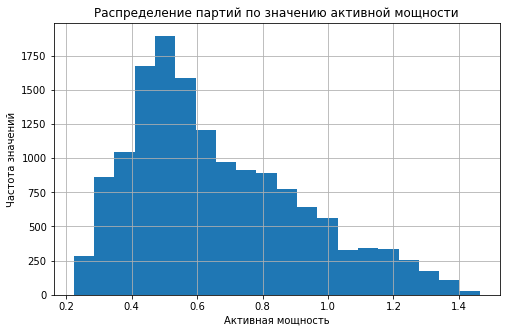

In [82]:
analysis_chart = plot_hist(data = data_arc_new['активная_мощность'],
                           bins = 20,
                           title = 'Распределение партий по значению активной мощности')

analysis_chart.set_xlabel("Активная мощность");

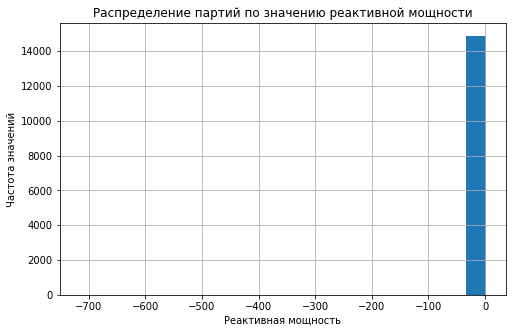

In [83]:
analysis_chart = plot_hist(data = data_arc_new['реактивная_мощность'],
                           bins = 20,
                           title = 'Распределение партий по значению реактивной мощности')

analysis_chart.set_xlabel("Реактивная мощность");

На графике сразу видна аномалия, избавимся от неё.

In [84]:
data_arc_new[data_arc_new['реактивная_мощность'] < 0]

,key,начало_нагрева_дугой,конец_нагрева_дугой,активная_мощность,реактивная_мощность
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924


Заменим отрицательное значение вторым минимумом столбца.

In [85]:
data_arc_new['реактивная_мощность'].nsmallest(2)

9780   -715.479924
709       0.153777
Name: реактивная_мощность, dtype: float64

In [86]:
def remove_negative(data):
    if data < 0:
        return 0.153777
    return data

In [87]:
data_arc_new['реактивная_мощность'] = data_arc_new['реактивная_мощность'].apply(remove_negative)
data_arc_new['реактивная_мощность'].describe()

count    14876.000000
mean         0.487093
std          0.197625
min          0.153777
25%          0.337175
50%          0.441639
75%          0.608201
max          1.270284
Name: реактивная_мощность, dtype: float64

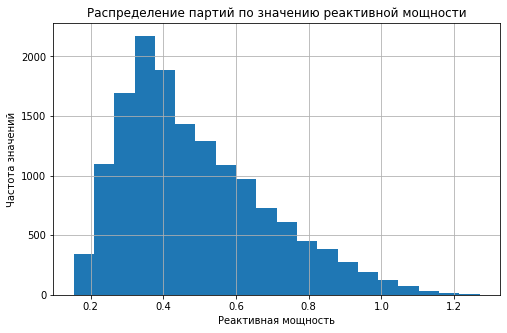

In [88]:
analysis_chart = plot_hist(data = data_arc_new['реактивная_мощность'],
                           bins = 20,
                           title = 'Распределение партий по значению реактивной мощности')

analysis_chart.set_xlabel("Реактивная мощность");

Добавим в данные новый признак, который объединит активную и реактивную мощность в один значимый признак - общую затрачиваемую мощность по следующей формуле:

$$S = \sqrt{P^2 + Q^2},$$

где S - общая мощность, P - активная мощность, а Q - реактивная мощность.

In [89]:
data_arc_new['полная_мощность'] = (data_arc_new['активная_мощность']**2 + data_arc_new['реактивная_мощность']**2)**(0.5)

Также добавим признак, с временем нагрева, которое получим, вычтя из времени окончания нагрева время начала нагрева.

In [90]:
data_arc_new['время_нагрева'] = (data_arc_new['конец_нагрева_дугой'] - data_arc_new['начало_нагрева_дугой']).astype('timedelta64[s]').astype(int)

Добавим и итоговые затраты электроэнергии, помножив полную мощность на время нагрева.

In [91]:
data_arc_new['затраты_электроэнергии'] = data_arc_new['полная_мощность'] * data_arc_new['время_нагрева']

Теперь, будем для каждой партии считать среднее значение мощности. Также посчитаем суммарную электроэнергию.

In [92]:
data_arc_new_columns = {
    'key'                    : 'count', 
    'начало_нагрева_дугой'   : 'min',
    'конец_нагрева_дугой'    : 'max',
    'активная_мощность'      : 'mean',
    'реактивная_мощность'    : 'mean',
    'полная_мощность'        : 'mean',
    'время_нагрева'          : 'sum',
    'затраты_электроэнергии' : 'sum'
}

data_arc_new = data_arc_new.groupby('key').agg(data_arc_new_columns).rename(columns={'key':'количество_легирующих_циклов'})

Создадим таблицу для хранения времени начала и конца нагрева дугой для партий.

In [93]:
data_arc_time_new = data_arc_new[['начало_нагрева_дугой', 'конец_нагрева_дугой']]
display(data_arc_time_new.head())

,начало_нагрева_дугой,конец_нагрева_дугой
key,,
1,2019-05-03 11:02:14,2019-05-03 11:28:37
2,2019-05-03 11:34:14,2019-05-03 11:53:18
3,2019-05-03 12:06:54,2019-05-03 12:32:19
4,2019-05-03 12:39:37,2019-05-03 12:57:50
5,2019-05-03 13:11:13,2019-05-03 13:33:55


In [94]:
data_arc_new.drop(['начало_нагрева_дугой', 'конец_нагрева_дугой'], axis=1, inplace=True) 
display(data_arc_new.head())

,количество_легирующих_циклов,активная_мощность,реактивная_мощность,полная_мощность,время_нагрева,затраты_электроэнергии
key,,,,,,
1,5,0.607346,0.428564,0.743747,1098,770.282114
2,4,0.534852,0.363339,0.647087,811,481.760005
3,5,0.812728,0.587491,1.003845,655,722.837668
4,4,0.676622,0.514248,0.850010,741,683.455597
5,4,0.563238,0.421998,0.704245,869,512.169934


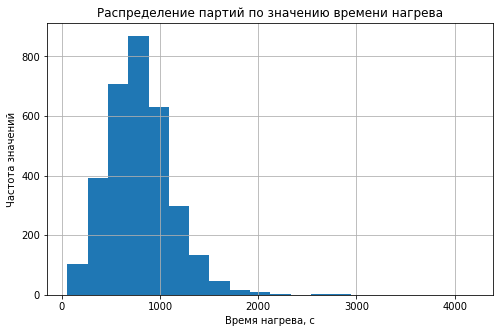

In [95]:
analysis_chart = plot_hist(data = data_arc_new['время_нагрева'],
                           bins = 20,
                           title = 'Распределение партий по значению времени нагрева')

analysis_chart.set_xlabel("Время нагрева, с");

In [96]:
display(data_arc_new['время_нагрева'].describe())

count    3214.000000
mean      794.579029
std       332.448622
min        57.000000
25%       571.000000
50%       770.000000
75%       983.000000
max      4189.000000
Name: время_нагрева, dtype: float64

Изучим партии с временем нагрева больше получаса (1800 с).

In [97]:
display(data_arc_new.loc[data_arc_new['время_нагрева'] > 1800]
        .sort_values(by='количество_легирующих_циклов', ascending=False))

,количество_легирующих_циклов,активная_мощность,реактивная_мощность,полная_мощность,время_нагрева,затраты_электроэнергии
key,,,,,,
2108,16,0.669175,0.474343,0.820929,2739,2151.752807
1513,15,0.775490,0.571533,0.964436,2526,2380.879281
1689,15,0.825042,0.596603,1.019218,4189,4546.405812
322,13,0.685754,0.504934,0.851966,2658,2026.007227
46,13,0.706174,0.542457,0.891672,2919,2306.073920
44,12,0.608250,0.435102,0.748429,2063,1393.802417
638,11,0.661000,0.452892,0.801596,2067,1654.779561
2917,11,0.586461,0.453019,0.741930,2006,1224.527008
1880,11,0.559006,0.387556,0.680447,2755,1851.427463


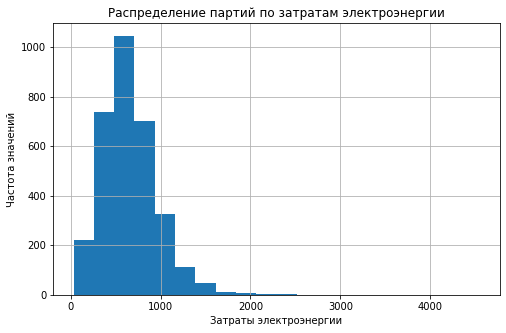

In [99]:
analysis_chart = plot_hist(data = data_arc_new['затраты_электроэнергии'],
                           bins = 20,
                           title = 'Распределение партий по затратам электроэнергии')

analysis_chart.set_xlabel("Затраты электроэнергии");

Добавим новый признак - сумму объёмов подаваемого материала для каждой партии.

In [100]:
data_bulk_new['общий_объём_материала'] = data_bulk_new.sum(axis=1)
display(data_bulk_new['общий_объём_материала'].describe())

count    3129.000000
mean     2219.886865
std       959.185969
min        93.000000
25%      1419.000000
50%      2220.000000
75%      3051.000000
max      4304.000000
Name: общий_объём_материала, dtype: float64

Отметим время первого и последнего замера температуры.

In [101]:
data_temp_time_new = data_temp_new
data_temp_time_new['время_начального_замера'] = data_temp_time_new['время_замера']
data_temp_time_new['время_последнего_замера'] = data_temp_time_new['время_замера']
data_temp_time_new_columns = {
    'время_начального_замера' : 'first',
    'время_последнего_замера' : 'last'
}

data_temp_time_new = data_temp_time_new.groupby('key').agg(data_temp_time_new_columns)

display(data_temp_time_new.head())

,время_начального_замера,время_последнего_замера
key,,
1,2019-05-03 11:02:04,2019-05-03 11:30:38
2,2019-05-03 11:34:04,2019-05-03 11:55:09
3,2019-05-03 12:06:44,2019-05-03 12:35:57
4,2019-05-03 12:39:27,2019-05-03 12:59:47
5,2019-05-03 13:11:03,2019-05-03 13:36:39


Добавим в таблицу с температурой новые колонки с начальной, конечной и минимальной температурой.

Перед этим выделим конечную температуру в отдельный столбец, чтобы избежать утечки целевого признака.

In [102]:
data_temp_fin = pd.DataFrame(data_temp_new, columns=['key', 'температура'])
data_temp_fin['конечная_температура'] = data_temp_new['температура']

data_temp_fin = data_temp_fin.groupby('key').agg({'конечная_температура': 'last'})

data_temp_fin['конечная_температура'] = data_temp_fin['конечная_температура'].astype(int)
data_temp_fin = data_temp_fin['конечная_температура']
data_temp_fin.name = None

display(data_temp_fin)

key
1       1613
2       1602
3       1599
4       1625
5       1602
        ... 
3237       0
3238       0
3239       0
3240       0
3241       0
Length: 3216, dtype: int64

Удаляем конечные значения температуры из оригинальной таблицы.

In [103]:
for key in data_temp_fin.index:
    rows = (data_temp_new['key'] == key) & (data_temp_new['температура'] == data_temp_fin.loc[key])
    data_temp_new.loc[rows, 'температура'] = None

In [104]:
data_temp_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   key                      18092 non-null  int64         
 1   время_замера             18092 non-null  datetime64[ns]
 2   температура              11639 non-null  float64       
 3   время_начального_замера  18092 non-null  datetime64[ns]
 4   время_последнего_замера  18092 non-null  datetime64[ns]
dtypes: datetime64[ns](3), float64(1), int64(1)
memory usage: 706.8 KB


In [105]:
data_temp_new['начальная_температура'] = data_temp_new['температура']
data_temp_new['минимальная_температура'] = data_temp_new['температура']

data_temp_new_columns = {
    'начальная_температура'   : 'first',
    'минимальная_температура' : 'min'
}

data_temp_new = data_temp_new.groupby('key').agg(data_temp_new_columns)

data_temp_new['конечная_температура'] = data_temp_fin

display(data_temp_new.head())

,начальная_температура,минимальная_температура,конечная_температура
key,,,
1,1571.0,1571.0,1613
2,1581.0,1577.0,1602
3,1596.0,1596.0,1599
4,1601.0,1601.0,1625
5,1576.0,1576.0,1602


In [106]:
data_temp_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3216 entries, 1 to 3241
Data columns (total 3 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   начальная_температура    3213 non-null   float64
 1   минимальная_температура  3213 non-null   float64
 2   конечная_температура     3216 non-null   int64  
dtypes: float64(2), int64(1)
memory usage: 100.5 KB


Технология производства стали требует поддержания температуры выше 1400 градусов Цельсия, удалим значения ниже 1400, а также все заполненные нулями значения и значения NaN.

In [107]:
data_temp_new['начальная_температура'] = data_temp_new['начальная_температура'].fillna(0)
data_temp_new['минимальная_температура'] = data_temp_new['минимальная_температура'].fillna(0)

data_temp_new = data_temp_new.loc[data_temp_new['минимальная_температура'] > 1400]

data_temp_new['начальная_температура'] = data_temp_new['начальная_температура'].astype(int)
data_temp_new['минимальная_температура'] = data_temp_new['минимальная_температура'].astype(int)

display(data_temp_new.head())

,начальная_температура,минимальная_температура,конечная_температура
key,,,
1,1571,1571,1613
2,1581,1577,1602
3,1596,1596,1599
4,1601,1601,1625
5,1576,1576,1602


In [108]:
print("Количество совпадений признака минимальная_температура с таргетом:" ,
      (data_temp_new['минимальная_температура'] == data_temp_new['конечная_температура']).sum()
     )

Количество совпадений признака минимальная_температура с таргетом: 0


Избавимся от данных без значения признака конечная_температура.

In [110]:
data_temp_new = data_temp_new[data_temp_new['конечная_температура'] > 0]

In [111]:
display(data_temp_new.describe())

,начальная_температура,минимальная_температура,конечная_температура
count,2470.000000,2470.000000,2470.000000
mean,1588.910931,1580.242105,1595.342510
std,25.006572,19.867251,16.037954
min,1519.000000,1519.000000,1541.000000
25%,1572.000000,1569.000000,1587.000000
50%,1587.000000,1580.000000,1593.000000
75%,1605.000000,1590.000000,1599.000000
max,1679.000000,1673.000000,1700.000000


In [112]:
data_temp_new.isna().sum()

начальная_температура      0
минимальная_температура    0
конечная_температура       0
dtype: int64

Конечная температура - целевой признак, в ней пропусков нет.

На этом будем считать анализ и предобработку отдельных таблиц завершённым. Продолжим предобработку после объединения данных.

## Объединение данных

Объединим таблицы со временем.

In [113]:
data_arc_time_new.info()
data_bulk_time_new.info()
data_wire_time_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3214 entries, 1 to 3241
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   начало_нагрева_дугой  3214 non-null   datetime64[ns]
 1   конец_нагрева_дугой   3214 non-null   datetime64[ns]
dtypes: datetime64[ns](2)
memory usage: 75.3 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   key                        3129 non-null   int64         
 1   время_подачи_материала_1   252 non-null    datetime64[ns]
 2   время_подачи_материала_2   22 non-null     datetime64[ns]
 3   время_подачи_материала_3   1298 non-null   datetime64[ns]
 4   время_подачи_материала_4   1014 non-null   datetime64[ns]
 5   время_подачи_материала_5   77 non-null     datetime64[ns]
 6   вре

In [114]:
time_names = [data_arc_time_new, data_bulk_time_new, data_wire_time_new]
total_time = data_temp_time_new
for name in time_names:
    total_time = total_time.merge(name, on=['key'])

In [115]:
total_time['время_начального_замера'] = pd.to_datetime(total_time['время_начального_замера'])
total_time['время_последнего_замера'] = pd.to_datetime(total_time['время_последнего_замера'])
total_time['начало_нагрева_дугой'] = pd.to_datetime(total_time['начало_нагрева_дугой'])
total_time['конец_нагрева_дугой'] = pd.to_datetime(total_time['конец_нагрева_дугой'])

for i in range(1,16):
    total_time[f'время_подачи_материала_{i}'] = pd.to_datetime(total_time[f'время_подачи_материала_{i}'])
for i in range(1,10):
    total_time[f'время_подачи_проволочных_материалов_{i}'] = pd.to_datetime(total_time[f'время_подачи_проволочных_материалов_{i}'])

In [116]:
display(total_time.head(10))

,key,время_начального_замера,время_последнего_замера,начало_нагрева_дугой,конец_нагрева_дугой,время_подачи_материала_1,время_подачи_материала_2,время_подачи_материала_3,время_подачи_материала_4,время_подачи_материала_5,...,время_подачи_материала_15,время_подачи_проволочных_материалов_1,время_подачи_проволочных_материалов_2,время_подачи_проволочных_материалов_3,время_подачи_проволочных_материалов_4,время_подачи_проволочных_материалов_5,время_подачи_проволочных_материалов_6,время_подачи_проволочных_материалов_7,время_подачи_проволочных_материалов_8,время_подачи_проволочных_материалов_9
0,1,2019-05-03 11:02:04,2019-05-03 11:30:38,2019-05-03 11:02:14,2019-05-03 11:28:37,NaT,NaT,NaT,2019-05-03 11:28:48,NaT,...,2019-05-03 11:10:43,2019-05-03 11:06:19,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2,2019-05-03 11:34:04,2019-05-03 11:55:09,2019-05-03 11:34:14,2019-05-03 11:53:18,NaT,NaT,NaT,2019-05-03 11:36:50,NaT,...,2019-05-03 11:44:39,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,3,2019-05-03 12:06:44,2019-05-03 12:35:57,2019-05-03 12:06:54,2019-05-03 12:32:19,NaT,NaT,NaT,2019-05-03 12:32:39,NaT,...,2019-05-03 12:16:16,2019-05-03 12:11:46,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,4,2019-05-03 12:39:27,2019-05-03 12:59:47,2019-05-03 12:39:37,2019-05-03 12:57:50,NaT,NaT,NaT,2019-05-03 12:43:22,NaT,...,2019-05-03 12:46:36,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,5,2019-05-03 13:11:03,2019-05-03 13:36:39,2019-05-03 13:11:13,2019-05-03 13:33:55,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,...,2019-05-03 13:30:47,2019-05-03 13:20:44,2019-05-03 13:15:34,NaT,NaT,NaT,NaT,NaT,NaT,NaT
5,6,2019-05-03 13:46:41,2019-05-03 14:11:38,2019-05-03 13:46:51,2019-05-03 14:09:24,NaT,NaT,NaT,2019-05-03 13:57:27,NaT,...,2019-05-03 14:03:15,2019-05-03 13:57:27,2019-05-03 13:48:52,NaT,NaT,NaT,NaT,NaT,NaT,NaT
6,7,2019-05-03 14:16:36,2019-05-03 14:45:40,2019-05-03 14:16:46,2019-05-03 14:41:15,NaT,NaT,NaT,2019-05-03 14:18:58,NaT,...,2019-05-03 14:27:16,2019-05-03 14:18:58,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
7,8,2019-05-03 14:53:46,2019-05-03 15:20:41,2019-05-03 14:53:56,2019-05-03 15:17:48,NaT,NaT,NaT,2019-05-03 15:17:58,NaT,...,2019-05-03 15:05:33,2019-05-03 15:01:30,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
8,9,2019-05-03 15:36:33,2019-05-03 16:06:44,2019-05-03 15:36:43,2019-05-03 16:02:49,NaT,NaT,NaT,2019-05-03 16:03:08,NaT,...,2019-05-03 15:52:39,2019-05-03 15:45:44,2019-05-03 15:39:37,NaT,NaT,NaT,NaT,NaT,NaT,NaT
9,10,2019-05-03 16:13:59,2019-05-03 16:39:50,2019-05-03 16:14:09,2019-05-03 16:37:51,NaT,NaT,NaT,NaT,NaT,...,2019-05-03 16:29:56,2019-05-03 16:27:00,2019-05-03 16:22:36,NaT,NaT,NaT,NaT,NaT,NaT,NaT


Согласно техническому заданию, каждый этап должен начинаться и заканчиваться замером температуры. Найдём и удалим нарушения.

In [117]:
total_time_columns = total_time.select_dtypes('datetime').columns

total_time['max'] = total_time['время_последнего_замера'] >= total_time[total_time_columns].max(axis=1)
max_time = len(total_time[total_time['max'] == False][total_time_columns])

total_time['min'] = total_time['время_начального_замера'] <= total_time[total_time_columns].min(axis=1)
min_time = len(total_time[total_time['min'] == False][total_time_columns])

print(f'Количество партий с нарушением в конце каждого этапа - {max_time}.')
print(f'Количество партий с нарушением в начале каждого этапа - {min_time}.')

Количество партий с нарушением в конце каждого этапа - 0.
Количество партий с нарушением в начале каждого этапа - 0.


Нарушения не обнаружены. Создадим общую таблицу.

In [118]:
data = data_arc_new

data = data.merge(data_bulk_new, on=['key'])
data = data.merge(data_gas_new,  on=['key'])
data = data.merge(data_temp_new, on=['key'])
data = data.merge(data_wire_new, on=['key'])
    
display(data.head())

,key,количество_легирующих_циклов,активная_мощность,реактивная_мощность,полная_мощность,время_нагрева,затраты_электроэнергии,объём_подаваемого_материала_1,объём_подаваемого_материала_2,объём_подаваемого_материала_3,...,конечная_температура,объём_подаваемых_проволочных_материалов_1,объём_подаваемых_проволочных_материалов_2,объём_подаваемых_проволочных_материалов_3,объём_подаваемых_проволочных_материалов_4,объём_подаваемых_проволочных_материалов_5,объём_подаваемых_проволочных_материалов_6,объём_подаваемых_проволочных_материалов_7,объём_подаваемых_проволочных_материалов_8,объём_подаваемых_проволочных_материалов_9
0,1,5,0.607346,0.428564,0.743747,1098,770.282114,0.0,0.0,0.0,...,1613,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,4,0.534852,0.363339,0.647087,811,481.760005,0.0,0.0,0.0,...,1602,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,5,0.812728,0.587491,1.003845,655,722.837668,0.0,0.0,0.0,...,1599,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,4,0.676622,0.514248,0.850010,741,683.455597,0.0,0.0,0.0,...,1625,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,4,0.563238,0.421998,0.704245,869,512.169934,0.0,0.0,0.0,...,1602,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Исследовательский анализ и предобработка данных объединённого датафрейма

Изучим корреляцию входных и целевого признака.

In [120]:
data = data.drop('key', axis=1)

In [121]:
data_corr = data.corr()
display(data_corr)

,количество_легирующих_циклов,активная_мощность,реактивная_мощность,полная_мощность,время_нагрева,затраты_электроэнергии,объём_подаваемого_материала_1,объём_подаваемого_материала_2,объём_подаваемого_материала_3,объём_подаваемого_материала_4,...,конечная_температура,объём_подаваемых_проволочных_материалов_1,объём_подаваемых_проволочных_материалов_2,объём_подаваемых_проволочных_материалов_3,объём_подаваемых_проволочных_материалов_4,объём_подаваемых_проволочных_материалов_5,объём_подаваемых_проволочных_материалов_6,объём_подаваемых_проволочных_материалов_7,объём_подаваемых_проволочных_материалов_8,объём_подаваемых_проволочных_материалов_9
количество_легирующих_циклов,1.000000,0.031634,0.030357,0.031321,0.798594,0.711393,0.097596,0.093158,0.107031,-0.005299,...,0.180286,0.137477,0.078181,0.055224,0.113793,NaN,0.053350,0.073772,0.043897,-0.024735
активная_мощность,0.031634,1.000000,0.965294,0.995390,0.047920,0.396106,0.022453,0.002669,0.026487,0.021827,...,0.039634,0.035817,-0.014628,0.019258,-0.005447,NaN,0.010539,-0.003787,-0.005262,-0.006488
реактивная_мощность,0.030357,0.965294,1.000000,0.985871,0.042040,0.387426,0.018226,-0.000718,0.022567,0.022569,...,0.032808,0.043010,-0.014424,0.020605,-0.004978,NaN,0.006196,0.003450,-0.012990,0.002624
полная_мощность,0.031321,0.995390,0.985871,1.000000,0.046052,0.396045,0.021088,0.001486,0.025310,0.022214,...,0.037334,0.038778,-0.014697,0.019860,-0.005308,NaN,0.009070,-0.001139,-0.008135,-0.003045
время_нагрева,0.798594,0.047920,0.042040,0.046052,1.000000,0.900371,0.102693,0.038134,0.091553,-0.029150,...,0.278310,0.055260,0.054568,0.033244,0.054762,NaN,0.042149,0.027602,0.017777,-0.011757
затраты_электроэнергии,0.711393,0.396106,0.387426,0.396045,0.900371,1.000000,0.095316,0.037700,0.088693,-0.022108,...,0.256232,0.060330,0.047385,0.036211,0.047717,NaN,0.047060,0.021009,0.014921,-0.011280
объём_подаваемого_материала_1,0.097596,0.022453,0.018226,0.021088,0.102693,0.095316,1.000000,0.224677,-0.011538,0.041662,...,-0.075283,0.013796,-0.009229,0.020204,0.146276,NaN,0.148509,0.083432,-0.019579,0.011013
объём_подаваемого_материала_2,0.093158,0.002669,-0.000718,0.001486,0.038134,0.037700,0.224677,1.000000,-0.046953,0.040756,...,-0.082481,-0.169643,-0.039070,0.223188,0.699339,NaN,0.558882,0.431735,-0.005285,-0.006857
объём_подаваемого_материала_3,0.107031,0.026487,0.022567,0.025310,0.091553,0.088693,-0.011538,-0.046953,1.000000,-0.295526,...,-0.036877,0.037727,0.094966,0.005840,-0.040582,NaN,0.007174,-0.019475,0.004885,0.004668
объём_подаваемого_материала_4,-0.005299,0.021827,0.022569,0.022214,-0.029150,-0.022108,0.041662,0.040756,-0.295526,1.000000,...,0.188016,0.298103,-0.268029,-0.039326,0.034390,NaN,-0.011507,0.033822,0.007781,-0.058236


Удалим признаки с корреляцией больше 0.8.

In [122]:
for feature_1 in data_corr.index:
    for feature_2 in data_corr.columns:
        if (feature_1 != feature_2) & (data_corr.loc[feature_1, feature_2] > 0.8):
            print(f'{feature_1} X {feature_2}')

активная_мощность X реактивная_мощность
активная_мощность X полная_мощность
реактивная_мощность X активная_мощность
реактивная_мощность X полная_мощность
полная_мощность X активная_мощность
полная_мощность X реактивная_мощность
время_нагрева X затраты_электроэнергии
затраты_электроэнергии X время_нагрева
объём_подаваемого_материала_9 X объём_подаваемых_проволочных_материалов_8
начальная_температура X минимальная_температура
минимальная_температура X начальная_температура
объём_подаваемых_проволочных_материалов_8 X объём_подаваемого_материала_9


In [123]:
del_col = ['активная_мощность', 'реактивная_мощность', 'время_нагрева',
           'объём_подаваемого_материала_9', 'начальная_температура']
data = data.drop(del_col, axis=1)

In [124]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2324 entries, 0 to 2323
Data columns (total 30 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   количество_легирующих_циклов               2324 non-null   int64  
 1   полная_мощность                            2324 non-null   float64
 2   затраты_электроэнергии                     2324 non-null   float64
 3   объём_подаваемого_материала_1              2324 non-null   float64
 4   объём_подаваемого_материала_2              2324 non-null   float64
 5   объём_подаваемого_материала_3              2324 non-null   float64
 6   объём_подаваемого_материала_4              2324 non-null   float64
 7   объём_подаваемого_материала_5              2324 non-null   float64
 8   объём_подаваемого_материала_6              2324 non-null   float64
 9   объём_подаваемого_материала_7              2324 non-null   float64
 10  объём_подаваемого_матери

Проверим данные на наличие явных дубликатов.

In [125]:
print(data.duplicated().sum())

0


Явных дубликатов не обнаружено, неявные дубликаты невозможны из-за того, что все поля числовые.

## Подготовка данных

Разобьём таблицу на тренировочную и тестовую выборки.

In [126]:
RANDOM_STATE = 80724

X_train, X_test, y_train, y_test = train_test_split(
    data.drop('конечная_температура', axis=1),
    data['конечная_температура'],
    test_size=0.25,
    random_state=RANDOM_STATE
)

Масштабируем данные.

In [127]:
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Данные готовы. Приступим к обучении моделей.

## Обучение моделей машинного обучения

Были выбраны четыре модели - LinearRegression, DecisionTreeRegressor, LGBMRegressor и CatBoostRegressor. Обучим каждую из них и проверим их результаты на кросс-валидации.

### Обучение линейной регрессии

In [70]:
%%time

regressor = LinearRegression()

cv_mae_lr = abs((cross_val_score(regressor,
                              X_train, 
                              y_train, 
                              cv=5, 
                              scoring='neg_mean_absolute_error')).mean())

print('Среднее значение метрики MAE для модели LinearRegression =', cv_mae_lr)

Среднее значение метрики MAE для модели LinearRegression = 5.852095583673931
CPU times: user 191 ms, sys: 293 ms, total: 484 ms
Wall time: 407 ms


### Обучение DecisionTreeRegressor

In [71]:
%%time

regressor = DecisionTreeRegressor(random_state=RANDOM_STATE)
params = [{'max_depth':range(2, 5)}]

print('Подбираем значение максимальной глубины дерева с наилучшим показателем метрики.\n')

clf = GridSearchCV(regressor, params, scoring='neg_mean_absolute_error')
clf.fit(X_train, y_train)

print('Значение максимальной глубины дерева с наилучшим показателем метрики:', clf.best_params_, '\n')

cv_mae_dtr = abs(clf.best_score_)
print('Среднее значение метрики MAE для модели DecisionTreeRegressor =', cv_mae_dtr)

Подбираем значение максимальной глубины дерева с наилучшим показателем метрики.

Значение максимальной глубины дерева с наилучшим показателем метрики: {'max_depth': 4} 

Среднее значение метрики MAE для модели DecisionTreeRegressor = 6.564812738766423
CPU times: user 137 ms, sys: 20.1 ms, total: 157 ms
Wall time: 212 ms


### Обучение LGBMRegressor

In [72]:
%%time

regressor = LGBMRegressor(random_state=RANDOM_STATE)
params = [{'num_leaves':[50, 100, 200], 
           'learning_rate':[0.1, 0.2, 0.3]}]

print('Подбираем значения гиперпараметров с наилучшим показателем метрики.\n')

clf = GridSearchCV(regressor, params, scoring='neg_mean_absolute_error')
clf.fit(X_train, y_train)

print('Значение гиперпараметров с наилучшим показателем метрики:', clf.best_params_, '\n')

cv_mae_lgbmr = abs(clf.best_score_)
print('Среднее значение метрики MAE для модели LGBMRegressor =', cv_mae_lgbmr)

Подбираем значения гиперпараметров с наилучшим показателем метрики.

Значение гиперпараметров с наилучшим показателем метрики: {'learning_rate': 0.1, 'num_leaves': 100} 

Среднее значение метрики MAE для модели LGBMRegressor = 5.568709535656614
CPU times: user 2min 2s, sys: 1.03 s, total: 2min 3s
Wall time: 2min 4s


### Обучение CatBoostRegressor

In [73]:
%%time

regressor = CatBoostRegressor(random_state=RANDOM_STATE, verbose=False)
params = [{'learning_rate':[0.1, 0.2, 0.3, 0.4, 0.5]}]

print('Подбираем значения гиперпараметров с наилучшим показателем метрики.\n')

clf = GridSearchCV(regressor, params, scoring='neg_mean_absolute_error')
clf.fit(X_train, y_train)

print('Значение гиперпараметров с наилучшим показателем метрики:', clf.best_params_, '\n')

cv_mae_cbr = abs(clf.best_score_)
print('Среднее значение метрики MAE для модели CatBoostRegressor =', cv_mae_cbr)

Подбираем значения гиперпараметров с наилучшим показателем метрики.

Значение гиперпараметров с наилучшим показателем метрики: {'learning_rate': 0.1} 

Среднее значение метрики MAE для модели CatBoostRegressor = 5.6124399037150425
CPU times: user 1min 16s, sys: 1.82 s, total: 1min 18s
Wall time: 1min 37s


Лучшие результаты показала модель LGBMRegressor, с метрикой MAE равной 5.568709535656614.

## Выбор лучшей модели

Теперь найдём значение метрики МАЕ на тестовой выборке.

In [128]:
%%time

regressor = LGBMRegressor(random_state=RANDOM_STATE, learning_rate=0.1, num_leaves=100)
regressor.fit(X_train, y_train)

CPU times: user 4.09 s, sys: 6.29 ms, total: 4.1 s
Wall time: 4.08 s


LGBMRegressor(num_leaves=100, random_state=80724)

In [129]:
%%time

y_pred = regressor.predict(X_test)

CPU times: user 25.7 ms, sys: 251 µs, total: 25.9 ms
Wall time: 6.72 ms


In [130]:
mae_result = mean_absolute_error(y_test, y_pred)
print(mae_result)

5.454581532023236


Обучим модель-болванку и сравним её с результатом LGBMRegressor.

In [131]:
dummy_reg = DummyRegressor()
dummy_reg.fit(X_train, y_train)
y_test_pred_dummy = dummy_reg.predict(X_test)

dummy_test = mean_absolute_error(y_test, y_test_pred_dummy)

print(f'Значение метрики МАЕ на модели-болванке - {dummy_test}.')

Значение метрики МАЕ на модели-болванке - 8.36358761823788.


In [132]:
if mae_result > dummy_test:
    print(f'Значение метрики МАЕ на модели-болванке {dummy_test} показывает лучший результат.')
else:
    print(f'Значение метрики МАЕ на подобранной модели {mae_result} показывает лучший результат.')

if mae_result > 6.8:
    print(f'Значение метрики МАЕ {mae_result} не удовлетворяет критерию успеха.')
else:
    print(f'Значение метрики МАЕ {mae_result} удовлетворяет критерию успеха.')

Значение метрики МАЕ на подобранной модели 5.454581532023236 показывает лучший результат.
Значение метрики МАЕ 5.454581532023236 удовлетворяет критерию успеха.


Успешно.

## Общий вывод и рекомендации заказчику

Изучим вляиние входных признаков на результаты модели.

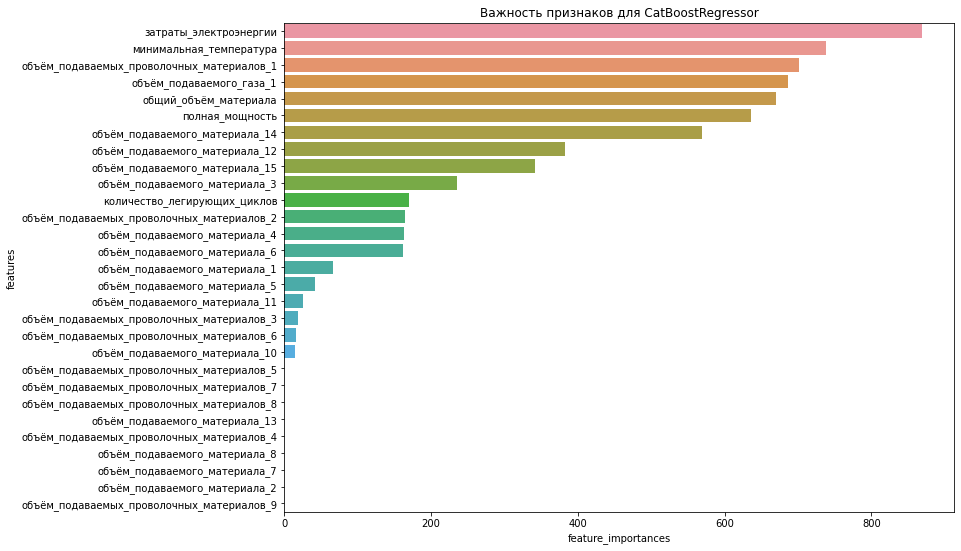

In [79]:
plot_data = {
    'features': data.drop('конечная_температура', axis=1).columns,
    'feature_importances': regressor.feature_importances_,
}

plot_data = pd.DataFrame(plot_data)
plot_data.sort_values(by='feature_importances', ascending=False, inplace=True)

plt.figure(figsize=(12, 9))

sns.barplot(x=plot_data['feature_importances'], y=plot_data['features'])

plt.title('Важность признаков для CatBoostRegressor')
plt.show()

Пять самых влиятельных признаков при определении конечной температуры:
- Затраты электроэнергии;
- Минимальная температура;
- Объём подаваемых проволочных материалов 1;
- Объём подаваемого газа;
- Общий объём материала.

# Вывод:

Во время работы было выполнено три шага:
1. Предобработка;
2. Обучение моделей;
3. Применение моделей и анализ результатов.

В процессе предобработки были обработаны пропуски и аномальные значения, а также было проверено отсутствие явных и неявных дубликатов. Мы подтвердили корректность и наглядность в названиях столбцов, добавили признаки *количество_легирующих_циклов*, *время_нагрева*, *начальная_температура*, *конечная_температура* и *минимальная_температура*. К тому же были добавлены признаки *полная_мощность* и *затраты_электроэнергии*, высчитанные по формуле, добавили признак *общий_объём_материала* - сумма объемов добавленного сыпучего материала.

После мы удалили партии с начальной температурой ниже технологического регламента в 1400°С и с пропусками в замерах температуры. Проверили на корректность времени определения температуры согласно регламенту. Провели корреляционные анализ с визуализацией корреляций. Выявели 3 признака сильно коррелирующие друг с другом. Удалили признаки реактивной и активной мощности, чтобы устранить мультиколлинеарность. Подготовили данные и разделили на 2 выборки train/test в соотношении 75/25 для дальнейшего обучения модели.

В процессе обучения моделей числовые признаки были масшатбированы и разбиты на тренировочную и тестовую выборки. На основе тренировочной выборки для четырёх выбранных моделей, LinearRegression, DecisionTreeRegressor, LGBMRegressor и CatBoostRegressor, были рассчитаны наилучшие гиперпараметры и рассчитана метрика МАЕ на кросс-валидации. Для каждой модели было записано время работы.

Лучшие результаты показала модель LGBMRegressor с результатом 5.568709535656614. Лучшие результаты на кросс-валидации показали модели градиентного бустинга, они смогли показать хорошее время и точность даже на плохих данных с большим числом пропусков. Второй по качеству можно считать модель линейной регрессии.

После применения модели была повторно рассчитана метрика МАЕ, также было рассчитано время предсказания и обучения модели. Значение метрики улучшилось в сравнении с кросс-валидацией и теперь составляет 5.454581532023236, что может говорить о рациональности применения модели LGBMRegressor в дальнейшем при решении подобных задач.

Если бы заказчик предоставил более полную информацию, с меньшим количеством пропуском, то результаты модели могли бы быть улучшены. К тому же, с решением задачи определения конечной температуры сплава может лучше справиться математическое моделирование, которое предлагает точные способы аналитического решения данной задачи.